In [1]:
import os.path
import urllib.request

if not os.path.exists('covtype.data.gz'):
    urllib.request.urlretrieve('http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz', 'covtype.data.gz')
    with gzip.open('covtype.data.gz', 'rb') as f_in:
        with open('covtype.data', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
if not os.path.exists('covtype.info'):
    urllib.request.urlretrieve('http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.info', 'covtype.info')
if not os.path.exists('old_covtype.info'):
    urllib.request.urlretrieve('http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/old_covtype.info', 'old_covtype.info')


In [2]:
%matplotlib inline
from pyspark.sql import SparkSession
import pandas as pd

import sys
sys.path.append('..')
from utils.pysparkutils import *

spark = SparkSession.builder.appName("forest-cover-type").getOrCreate()

In [3]:
spark.sparkContext.uiWebUrl

'http://a72ee1401eb0:4044'

In [4]:
data = spark.read.csv('covtype.data', inferSchema='true')
# Wilderness_Area and Soil_Type columns are one hot encoded
Wilderness_Area_cols = ['Wilderness_Area_' + str(i) for i in range(4)]
Soil_Type_cols = ['Soil_Type_' + str(i) for i in range(40)]

headers = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
          'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
          'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
          'Horizontal_Distance_To_Fire_Points', *Wilderness_Area_cols,
           *Soil_Type_cols, 'Cover_Type']
data = data.toDF(*headers)
data.printSchema()

root
 |-- Elevation: integer (nullable = true)
 |-- Aspect: integer (nullable = true)
 |-- Slope: integer (nullable = true)
 |-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
 |-- Vertical_Distance_To_Hydrology: integer (nullable = true)
 |-- Horizontal_Distance_To_Roadways: integer (nullable = true)
 |-- Hillshade_9am: integer (nullable = true)
 |-- Hillshade_Noon: integer (nullable = true)
 |-- Hillshade_3pm: integer (nullable = true)
 |-- Horizontal_Distance_To_Fire_Points: integer (nullable = true)
 |-- Wilderness_Area_0: integer (nullable = true)
 |-- Wilderness_Area_1: integer (nullable = true)
 |-- Wilderness_Area_2: integer (nullable = true)
 |-- Wilderness_Area_3: integer (nullable = true)
 |-- Soil_Type_0: integer (nullable = true)
 |-- Soil_Type_1: integer (nullable = true)
 |-- Soil_Type_2: integer (nullable = true)
 |-- Soil_Type_3: integer (nullable = true)
 |-- Soil_Type_4: integer (nullable = true)
 |-- Soil_Type_5: integer (nullable = true)
 |-- Soil_Type

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

wildernessAssembler = VectorAssembler(inputCols=Wilderness_Area_cols, outputCol='Wilderness_Area_features')
soilTypeAssembler = VectorAssembler(inputCols=Soil_Type_cols, outputCol='Soil_Type_features')
pipeline = Pipeline(stages=[wildernessAssembler, soilTypeAssembler])
data = pipeline.fit(data).transform(data)
data = data.drop(*Wilderness_Area_cols, *Soil_Type_cols)
data.printSchema()
data.count()

root
 |-- Elevation: integer (nullable = true)
 |-- Aspect: integer (nullable = true)
 |-- Slope: integer (nullable = true)
 |-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
 |-- Vertical_Distance_To_Hydrology: integer (nullable = true)
 |-- Horizontal_Distance_To_Roadways: integer (nullable = true)
 |-- Hillshade_9am: integer (nullable = true)
 |-- Hillshade_Noon: integer (nullable = true)
 |-- Hillshade_3pm: integer (nullable = true)
 |-- Horizontal_Distance_To_Fire_Points: integer (nullable = true)
 |-- Cover_Type: integer (nullable = true)
 |-- Wilderness_Area_features: vector (nullable = true)
 |-- Soil_Type_features: vector (nullable = true)



581012

In [6]:
from pyspark.sql.functions import monotonically_increasing_id
idCol = "Id"
labelCol = "Cover_Type"
dataWithId = data.withColumn(idCol, monotonically_increasing_id())
dataWithId.printSchema()

root
 |-- Elevation: integer (nullable = true)
 |-- Aspect: integer (nullable = true)
 |-- Slope: integer (nullable = true)
 |-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
 |-- Vertical_Distance_To_Hydrology: integer (nullable = true)
 |-- Horizontal_Distance_To_Roadways: integer (nullable = true)
 |-- Hillshade_9am: integer (nullable = true)
 |-- Hillshade_Noon: integer (nullable = true)
 |-- Hillshade_3pm: integer (nullable = true)
 |-- Horizontal_Distance_To_Fire_Points: integer (nullable = true)
 |-- Cover_Type: integer (nullable = true)
 |-- Wilderness_Area_features: vector (nullable = true)
 |-- Soil_Type_features: vector (nullable = true)
 |-- Id: long (nullable = false)



# Exploratory Data Analysis

We will do EDA on the sample of the data, since doing EDA on whole dataset might be expensive and sampled data is often good enough for EDA.

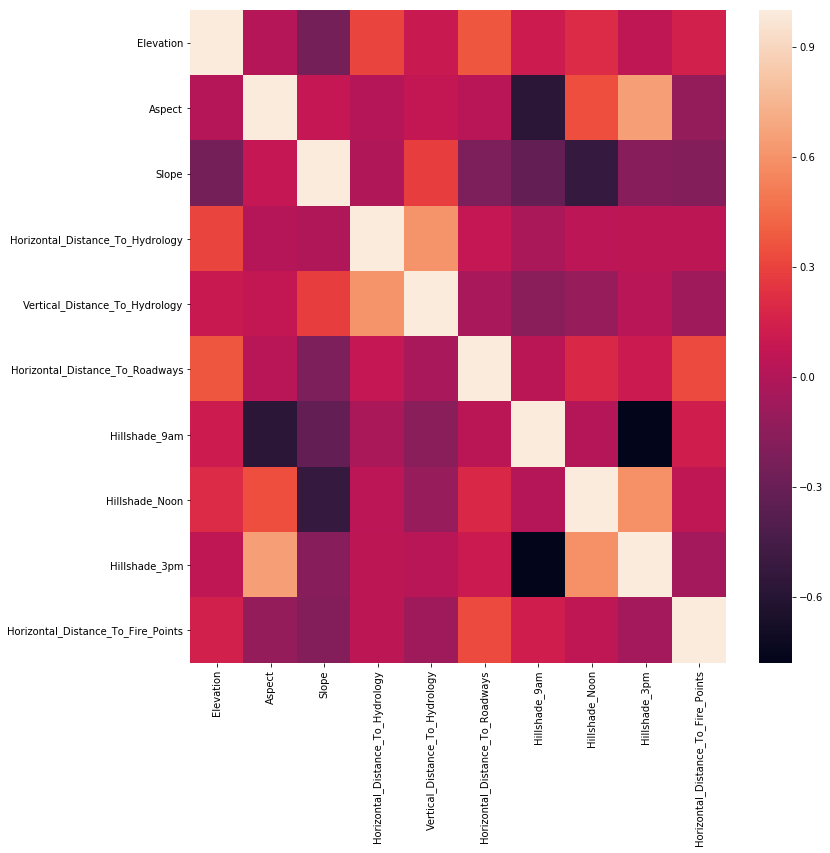

In [7]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

numericCols = [dtype[0] for dtype in data.dtypes if dtype[1] == 'int' or dtype[1] == 'double']
numericCols.remove(labelCol)
# numericCols.remove(idCol)

sampledData = data.select(numericCols).sample(False, 0.10)
corrAssembler = VectorAssembler(inputCols=numericCols, outputCol='corrFeatures')
corrTrain = corrAssembler.transform(sampledData)
corrMat = Correlation.corr(corrTrain, 'corrFeatures').head()

pdf = corrMat[0].toArray()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))

sns.heatmap(pdf, 
            xticklabels=numericCols,
            yticklabels=numericCols)

We will use Pandas dataframe, because it's output is prettier than Spark's native output.

In [8]:
des = data.select(*numericCols).describe()
des.toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Elevation,581012,2959.365300544567,279.98473425063605,1859,3858
Aspect,581012,155.65680743254873,111.91372100329541,0,360
Slope,581012,14.103703537964792,7.488241814480154,0,66
Horizontal_Distance_To_Hydrology,581012,269.42821662891646,212.54935559508118,0,1397
Vertical_Distance_To_Hydrology,581012,46.418855376481034,58.29523162688734,-173,601
Horizontal_Distance_To_Roadways,581012,2350.1466114297123,1559.2548698976059,0,7117
Hillshade_9am,581012,212.14604861861716,26.76988880528231,0,254
Hillshade_Noon,581012,223.31871630878535,19.768697153666487,0,254
Hillshade_3pm,581012,142.52826275533036,38.27452923141057,0,254


## Outlier Detection
Extreme Value Analysis.

In [9]:
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, udf, max
from pyspark.sql.types import DoubleType
import numpy as np

cols = data.columns[:]
cols.remove(labelCol)

assembler = VectorAssembler(inputCols=cols, outputCol='features')
data = assembler.transform(data)

def l2norm(v):
    x = v.toArray()
    d = np.linalg.norm(x)    
    return float(d)

l2_norm_udf = udf(l2norm, DoubleType())
data = data.withColumn('dist', l2_norm_udf(data['features']))
data.select('dist').describe().toPandas()

,summary,dist
0,count,581012
1,mean,4563.307848826347
2,stddev,1385.6620523086785
3,min,1953.585933610293
4,max,9366.020553041724


In [10]:
from pyspark.sql.functions import kurtosis, skewness

data.agg(skewness('dist')).show()
data.agg(kurtosis('dist')).show()


+------------------+
|    skewness(dist)|
+------------------+
|0.8140478753528405|
+------------------+

+-------------------+
|     kurtosis(dist)|
+-------------------+
|0.09715860921573372|
+-------------------+



In [11]:
from pyspark.sql.functions import mean, stddev_pop

avg = data.agg(mean('dist')).head()[0]
stddev = data.agg(stddev_pop('dist')).head()[0]

def z_score(val):
    return (val-avg)/stddev

data = data.withColumn('zScore', udf(z_score, DoubleType())(data['dist']))
data.select('zScore').describe().toPandas()

,summary,zScore
0,count,581012
1,mean,1.3844070591450395E-14
2,stddev,1.0000008605685315
3,min,-1.8833770880226572
4,max,3.466008778458579


In [12]:
data = data.filter((data.zScore <= 3) | (data.zScore >= -3))
data.count()


581012

In [13]:
data.groupby(labelCol).count().sort(labelCol).toPandas()

,Cover_Type,count
0,1,211840
1,2,283301
2,3,35754
3,4,2747
4,5,9493
5,6,17367
6,7,20510


# Classification

We can see we have a class imbalance problem. We have to do stratified split for train test split. Unforutantely Spark does not have any off the shelf stratified split function. So we will roll one our own.

In [14]:
train, test =  stratifiedSampling(data, labelCol, 0.8)
train.groupby(labelCol).count().sort(labelCol).toPandas()

,Cover_Type,count
0,1,169621
1,2,226587
2,3,28663
3,4,2213
4,5,7640
5,6,13986
6,7,16378


In [15]:
# %%script false

from pyspark.ml.feature import PCA
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

cols = data.columns[:]
cols.remove(labelCol)
pcaAssembler = VectorAssembler(inputCols=cols, outputCol='pcaFeatures')
pca = PCA(k=48, inputCol='pcaFeatures', outputCol='pcaOutFeatures')
classifier = RandomForestClassifier(featuresCol='pcaOutFeatures', 
                                    labelCol=labelCol,
                                    numTrees=50,
                                    maxDepth=25)
pcaPipeline = Pipeline(stages=[pcaAssembler, pca, classifier])
pcaPipelineModel = pcaPipeline.fit(train)
df = pcaPipelineModel.transform(train)

evaluator = MulticlassClassificationEvaluator(labelCol='Cover_Type')
evaluator.evaluate(df)

# df.select('pcaOutFeatures').show()
# df.describe('pcaOutFeatures').show()

pcaModel = pcaPipelineModel.stages[-1]
pcaModel.explainedVariance

Py4JJavaError: An error occurred while calling o234.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 63.0 failed 1 times, most recent failure: Lost task 1.0 in stage 63.0 (TID 1318, localhost, executor driver): java.lang.OutOfMemoryError: GC overhead limit exceeded
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$org$apache$spark$ml$tree$impl$RandomForest$$binSeqOp$1$1.apply(RandomForest.scala:454)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$org$apache$spark$ml$tree$impl$RandomForest$$binSeqOp$1$1.apply(RandomForest.scala:451)
	at scala.collection.immutable.HashMap$HashMap1.foreach(HashMap.scala:221)
	at scala.collection.immutable.HashMap$HashTrieMap.foreach(HashMap.scala:428)
	at scala.collection.immutable.HashMap$HashTrieMap.foreach(HashMap.scala:428)
	at org.apache.spark.ml.tree.impl.RandomForest$.org$apache$spark$ml$tree$impl$RandomForest$$binSeqOp$1(RandomForest.scala:451)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$12$$anonfun$apply$9.apply(RandomForest.scala:545)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$12$$anonfun$apply$9.apply(RandomForest.scala:545)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$12.apply(RandomForest.scala:545)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$12.apply(RandomForest.scala:534)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:800)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:800)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1587)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1586)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1586)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1820)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1769)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1758)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2027)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2048)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2067)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2092)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:938)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:743)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:742)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:742)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:563)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:198)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:139)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:45)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:82)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$org$apache$spark$ml$tree$impl$RandomForest$$binSeqOp$1$1.apply(RandomForest.scala:454)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$org$apache$spark$ml$tree$impl$RandomForest$$binSeqOp$1$1.apply(RandomForest.scala:451)
	at scala.collection.immutable.HashMap$HashMap1.foreach(HashMap.scala:221)
	at scala.collection.immutable.HashMap$HashTrieMap.foreach(HashMap.scala:428)
	at scala.collection.immutable.HashMap$HashTrieMap.foreach(HashMap.scala:428)
	at org.apache.spark.ml.tree.impl.RandomForest$.org$apache$spark$ml$tree$impl$RandomForest$$binSeqOp$1(RandomForest.scala:451)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$12$$anonfun$apply$9.apply(RandomForest.scala:545)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$12$$anonfun$apply$9.apply(RandomForest.scala:545)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$12.apply(RandomForest.scala:545)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$12.apply(RandomForest.scala:534)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:800)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:800)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 41986)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.6/socketserver.py", line 696, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "/usr/local/spark/python/pyspark/serializers.py", line 685, in read_int
    raise EOFError
EOFError
----------------------------------------


The following code was to find outliers based on Eucledian distance.

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

cols = data.columns[:]
cols.remove(labelCol)
assembler = VectorAssembler(inputCols=cols, outputCol='features')
classifier = RandomForestClassifier(featuresCol='features', 
                                    labelCol=labelCol,
                                    numTrees=20,
                                    maxDepth=25)
pipeline = Pipeline(stages=[assembler, classifier])
pipelineModel = pipeline.fit(train)
df = pipelineModel.transform(train)

evaluator = MulticlassClassificationEvaluator(labelCol=labelCol)
evaluator.evaluate(df)